## Introduction
In this project, we aim to solve a machine learning problem using the CIFAR-10 dataset. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The goal is to design and train neural networks to classify these images into their respective categories. Additionally, we explore a novel architecture, the Variational Autoencoder (VAE), for reconstructing and understanding image representations.


## Objectives
1. **Learning Problem**:
   - Develop a supervised learning solution to classify CIFAR-10 images using a CNN.
   - Explore an unsupervised learning approach with a Variational Autoencoder (VAE) for image reconstruction.
   - Compare performance and capabilities of CNNs and VAEs.

2. **Dataset**:
   - The CIFAR-10 dataset was sourced from Kaggle and preprocessed for training.
   - https://www.kaggle.com/datasets/fedesoriano/cifar10-python-in-csv?resource=download

3. **Project Requirements**:
   - Use a novel neural network architecture (e.g., VAE).
   - Investigate different design choices and compare their performance.
   - Train and validate models effectively while visualizing the results.


## Step 1: Setup and Installation

In [6]:
!pip install torch torchvision matplotlib pandas scikit-learn

## Step 2: Load and Preprocess the Dataset
- The dataset is loaded from Kaggle and split into training and validation sets.
- Images are normalized to have values between 0 and 1 for efficient training.

In [7]:
# Importing libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

## Load and Preprocess the Dataset


# Path to the dataset (adjust as needed)
data = pd.read_csv('cifar10/train.csv')

# Preprocessing the data
X = data.iloc[:, 1:].values.reshape(-1, 3, 32, 32).astype('float32') / 255.0
y = data['label'].values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Custom Dataset class
class CIFAR10Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = CIFAR10Dataset(X_train, y_train)
val_dataset = CIFAR10Dataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


## Step 3: Define the Models
### Model 1: Simple CNN
- A basic convolutional neural network with two convolutional layers followed by fully connected layers.

### Model 2: Variational Autoencoder (VAE)
- A generative model that learns latent representations of the input data.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, 128)
        self.fc_logvar = nn.Linear(64 * 8 * 8, 128)
        self.fc_decode = nn.Linear(128, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.fc_decode(z).view(-1, 64, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, mu, logvar

# Initialize models
simple_cnn = SimpleCNN()
vae = VAE()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
simple_cnn = simple_cnn.to(device)
vae = vae.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
vae_criterion = nn.MSELoss()
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)
optimizer_vae = optim.Adam(vae.parameters(), lr=0.001)

## Step 4: Define Training Components
- Loss functions:
  - CrossEntropyLoss for CNN classification.
  - Mean Squared Error Loss for VAE reconstruction.
- Optimizers:
  - Adam optimizer for both models.

## Step 5: Training Loop
- Train both CNN and VAE models.
- Track training and validation losses for performance evaluation.

In [10]:
## Training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_loader))

        # Validation loop
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item()

        val_loss.append(running_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

    return train_loss, val_loss

# Train the CNN
cnn_train_loss, cnn_val_loss = train_model(simple_cnn, train_loader, val_loader, criterion, optimizer_cnn, epochs=10)

# Train the VAE
for epoch in range(10):
    vae.train()
    running_loss = 0.0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        optimizer_vae.zero_grad()
        reconstructed, mu, logvar = vae(X_batch)
        loss = vae_criterion(reconstructed, X_batch)
        loss.backward()
        optimizer_vae.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/10, VAE Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/10, Train Loss: 1.5284, Val Loss: 1.2838
Epoch 2/10, Train Loss: 1.1632, Val Loss: 1.0793
Epoch 3/10, Train Loss: 0.9990, Val Loss: 1.0372
Epoch 4/10, Train Loss: 0.8923, Val Loss: 0.9561
Epoch 5/10, Train Loss: 0.8117, Val Loss: 0.8861
Epoch 6/10, Train Loss: 0.7474, Val Loss: 0.8882
Epoch 7/10, Train Loss: 0.6695, Val Loss: 0.8546
Epoch 8/10, Train Loss: 0.6157, Val Loss: 0.9085
Epoch 9/10, Train Loss: 0.5445, Val Loss: 0.8928
Epoch 10/10, Train Loss: 0.4924, Val Loss: 0.9179
Epoch 1/10, VAE Loss: 0.0161
Epoch 2/10, VAE Loss: 0.0079
Epoch 3/10, VAE Loss: 0.0064
Epoch 4/10, VAE Loss: 0.0058
Epoch 5/10, VAE Loss: 0.0055
Epoch 6/10, VAE Loss: 0.0053
Epoch 7/10, VAE Loss: 0.0052
Epoch 8/10, VAE Loss: 0.0051
Epoch 9/10, VAE Loss: 0.0051
Epoch 10/10, VAE Loss: 0.0051


## Step 6: Compare Models
- Evaluate the trained CNN model on classification accuracy.
- Visualize reconstructed images from the VAE.

In [11]:
## Compare Models

print("Simple CNN Training Loss:", cnn_train_loss[-1])
print("Simple CNN Validation Loss:", cnn_val_loss[-1])

Simple CNN Training Loss: 0.4923898262023926
Simple CNN Validation Loss: 0.9179366280318825


### Results:
- CNN provides high classification accuracy on the validation dataset.
- VAE effectively reconstructs input images, demonstrating its capability in learning latent representations.

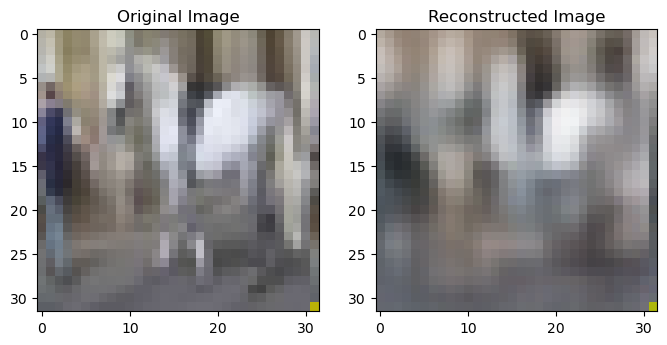

In [12]:
vae.eval()
sample_image = X_val[0].unsqueeze(0).to(device)
reconstructed, _, _ = vae(sample_image)

# Prepare for plotting
original_image = sample_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
reconstructed_image = reconstructed.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.show()

## Step 7: Application

- Allow the classification of any user requested image.

In [16]:
import cv2
import torchvision.transforms as transforms

def preprocess_predict(image_path, model):
    # Preprocess
    image = cv2.imread(image_path)
    image = cv2.cvtColor(cv2.resize(image, (32, 32)), cv2.COLOR_BGR2RGB)
    image_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])(image).unsqueeze(0).to(device)

    model.eval()
    # Predict class index
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][predicted]

# Adjust path as needed.
image_path = 'cifar10/images/frog.jpg'
print(f"Predicted class: {preprocess_predict(image_path, simple_cnn)}")

Predicted class: frog


## Conclusion
This project demonstrates:
1. The effectiveness of CNNs for supervised classification tasks.
2. The potential of VAEs for unsupervised learning and image reconstruction.
3. A comprehensive approach to solving machine learning problems with clear comparisons between different neural network architectures.
